In [5]:
# Core analysis packages
import numpy as np
import os, sys
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import anova
from patsy import dmatrices
import bff
import pingouin as pg

# Plotting packages
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns 
sns.set(style="ticks", color_codes=True)
sns.set_style("white")
sns.set_style({'xtick.bottom': True, 'ytick.left': True})
colorref = ["gray", "royalblue", "crimson", "goldenrod", "mediumorchid", "seagreen"]


# iPython magic commands
%matplotlib notebook
%load_ext autoreload
%autoreload 2
%autosave 120

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIG_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)  # fontsize of the figure title
cust_palette = sns.color_palette("Paired")[6:10]
cust_palette = [cust_palette[i] for i in [1,0,3,2]]

def median_split(S):
    return S > S.median()

Autosaving every 120 seconds


In [6]:
def ttest_ind(x1, x2, equivar=False, alpha=0.05, printres=False):
    n1 = len(x1)
    M1 = np.mean(x1)
    s1 = np.std(x1, ddof=1)
    n2 = len(x2)
    M2 = np.mean(x2)
    s2 = np.std(x2, ddof=1)
    
    # t-test
    [t, p] = stats.ttest_ind(x1, x2, equal_var=equivar)
    # cohen's d
    dof = n1 + n2 - 2
    sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / dof)
    d = np.abs(M1 - M2) / sp
    # degrees of freedom
    df = (s1**2/n1 + s2**2/n2)**2 / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))
    # confidence intervals (M1 - M2) ± ts(M1 - M2)
    se = np.sqrt(sp**2/n1 + sp**2/n2)
    CI = (M1 - M2) + np.array([-1,1])*stats.t.ppf(1-alpha/2, df, loc=0, scale=1)*se

    res = (t, df, p, d, CI[0], CI[1])
    if printres:
        print("t = %.5f, df = %.5f, p = %.5f, d = %.5f, CI = (%.5f, %.5f)" % res)
    else:
        return res

In [7]:
# Load file (from same directory as the notebook)
df = pd.read_excel(os.path.expanduser("princeton200.xlsx"), index_col=0)
df.head()

,GENDER,AGE,PARTY,TWITTER,TRUST,RATIONALUPDATE,RU1,RU2,RU3,RU4,...,SPT30,SUT30,APT31,AUT31,SPT31,SUT31,APT32,AUT32,SPT32,SUT32
Response ID,,,,,,,,,,,,,,,,,,,,,
R_ykkxJ7f40bzTEaZ,1,19,1,0,89,NaN,-3.0,14,14,-13,...,NaN,NaN,NaN,61.0,NaN,NaN,6.0,NaN,NaN,NaN
R_25QiP0xNXVnRkAG,0,20,1,0,80,NaN,9.0,-1,-6,0,...,41.0,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,66.0
R_3oT29XOVAcoi7Rn,1,19,1,0,77,NaN,0.0,-3,11,-37,...,NaN,NaN,NaN,NaN,NaN,35.0,NaN,NaN,1.0,NaN
R_2vZJNUGD4ve7StK,1,19,3,0,95,NaN,10.0,1,-11,-23,...,NaN,73.0,34.0,NaN,NaN,NaN,NaN,43.0,NaN,NaN
R_31oOzglBXE0nZO6,1,20,1,0,80,NaN,-27.0,-32,20,25,...,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN


In [8]:
def get_condnum(X):
    return np.mod(np.where(X)[-1], 4)
def sample(data, locs):
    idx = locs + 4*np.arange(locs.size)
    return data[idx]

In [9]:
# Extract columns with df.target or df["target"] or df.loc[:,"target"]
age = df.loc[:, "AGE"]
party = df.loc[:, "PARTY"]
twitter = df.loc[:, "TWITTER"]
trust = df.loc[:,"TRUST"]
partnum = np.arange(trust.size)

In [10]:
# Extract data with df.loc[:,"datastart":"dataend"]
RdeltaB = df.loc[:, "RU1":"RU32"]
convincing = df.loc[:, "APT1":"SUT32"]

cond_place = np.logical_not(np.isnan(convincing))

sz = RdeltaB.shape
itemnum = np.arange(sz[-1])
print(sz)

(200, 32)


In [11]:
#Compress condition-wise data into a single data matrix and labels
cond = np.array([get_condnum(cond_place.iloc[i,:]) for i in range(sz[0])])
# ^ Labels
convincing = np.array([sample(convincing.iloc[i], cond[i]) for i in range(sz[0])])

In [12]:
# Data and row-wise labels first
names = ["RdeltaB", "convincing", "cond", "itemnum", \
         "age", "party", "twitter", "trust", "partnum"]
data_packed = np.broadcast_arrays(RdeltaB, convincing, cond, itemnum)
# Then column-wise labels
cols = [np.tile(a, (sz[1],1)).T for a in [age, party, twitter, trust, partnum]]
data_packed += cols

data_unpacked = np.vstack([np.reshape(a, (1,-1), order="C") for a in data_packed]).T
DATA = pd.DataFrame(data=data_unpacked, columns=names)

ticklbl = ["Anec, Norm","Anec, Non-Norm","Sci, Norm","Sci, Non-Norm"]

DATA.head()

,RdeltaB,convincing,cond,itemnum,age,party,twitter,trust,partnum
0,-3.0,77.0,2.0,0.0,19.0,1.0,0.0,89.0,0.0
1,14.0,17.0,1.0,1.0,19.0,1.0,0.0,89.0,0.0
2,14.0,44.0,2.0,2.0,19.0,1.0,0.0,89.0,0.0
3,-13.0,15.0,0.0,3.0,19.0,1.0,0.0,89.0,0.0
4,-2.0,59.0,0.0,4.0,19.0,1.0,0.0,89.0,0.0


In [65]:
# Group and average data within participant and PE bin
AVDATA = DATA.groupby(["partnum", "cond"], as_index=False).mean()
AVDATA.shape

(800, 9)

In [14]:
AVDATA.loc[AVDATA["cond"]==0, "RdeltaB"].mean()

2.6924215296957947

# R

In [2]:
%load_ext rpy2.ipython
# %R library(lme4)
%R library(lmerTest)

import warnings
warnings.filterwarnings('ignore')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [16]:
map_dict = {0: "AP", 1: "AU", 2: "SP", 3: "SU"}
if "IC" in DATA:
    DATA = DATA.drop("IC", axis=1)
DATA.insert(8,"IC",DATA["cond"].map(map_dict))
DATA.head()

,RdeltaB,convincing,cond,itemnum,age,party,twitter,trust,IC,partnum
0,-3.0,77.0,2.0,0.0,19.0,1.0,0.0,89.0,SP,0.0
1,14.0,17.0,1.0,1.0,19.0,1.0,0.0,89.0,AU,0.0
2,14.0,44.0,2.0,2.0,19.0,1.0,0.0,89.0,SP,0.0
3,-13.0,15.0,0.0,3.0,19.0,1.0,0.0,89.0,AP,0.0
4,-2.0,59.0,0.0,4.0,19.0,1.0,0.0,89.0,AP,0.0


In [17]:
%Rpush DATA

<IPython.core.display.Javascript object>


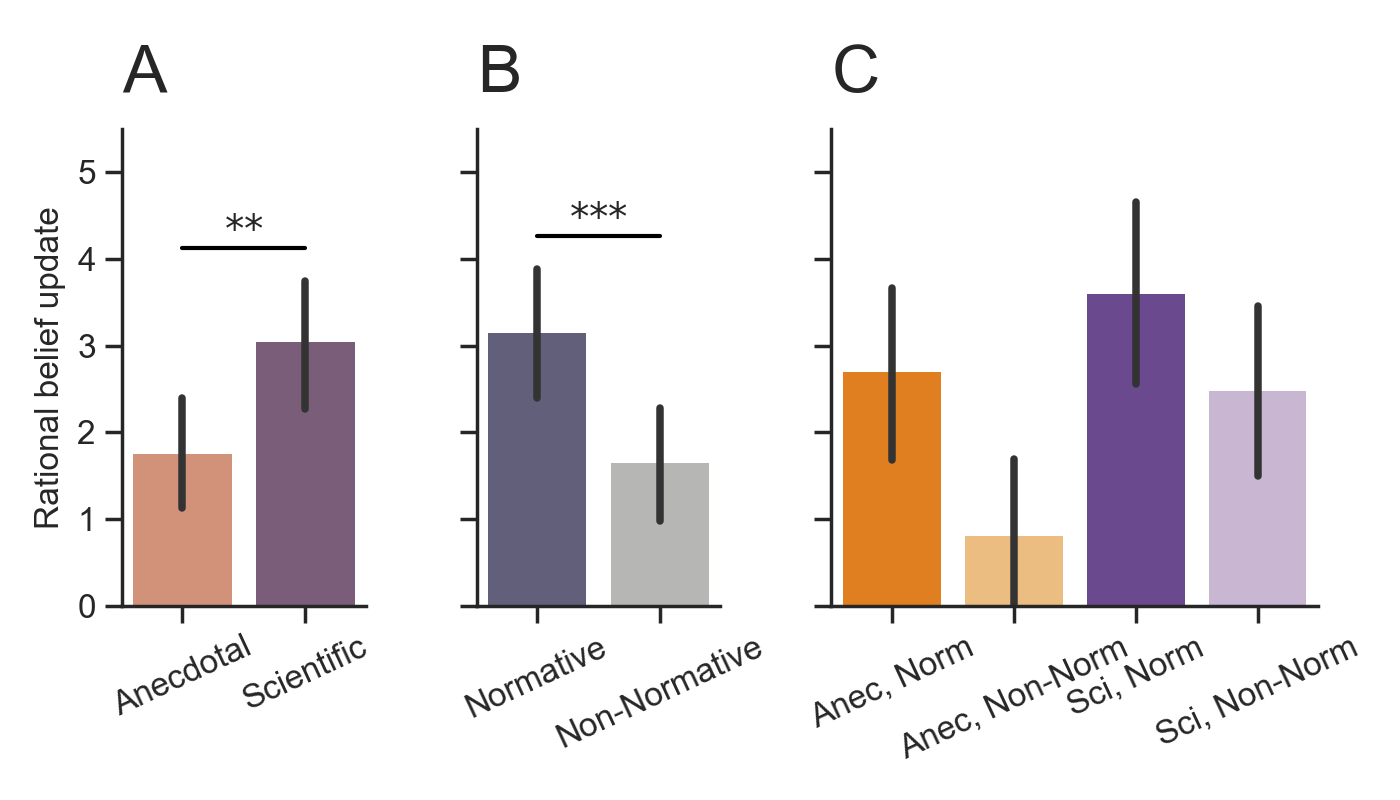

In [86]:
pal1 = ["#E18B6B", "#7E587E"]
pal = ["#5E5A80", "#B6B6B4"]


# Plotting
fig, ax = plt.subplots(1,3, figsize=(7,4), gridspec_kw={"width_ratios": [1,1,2]}, sharey=True)
sns.barplot(x="sci_anec", y="RdeltaB", data=AVDATA, \
            palette=pal1, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[0]) 
sns.despine()
ax[0].set_xlabel("");
ax[0].set_xticklabels(["Anecdotal", "Scientific"], rotation=25)
ax[0].set_ylabel("Rational belief update");
plt.ylim(0,7.5)
datahandles = np.array([L.get_xydata() for L in ax[0].get_lines()])
_, p = stats.ttest_rel(AVDATA.loc[AVDATA["sci_anec"]==0, "RdeltaB"], \
                       AVDATA.loc[AVDATA["sci_anec"]==1, "RdeltaB"])
bff.barplot_annotate_brackets(ax[0], 0, 1, p, datahandles, dh=0.05, fs=14)
bff.panellabel(ax[0], "A")


sns.barplot(x="pop_unpop", y="RdeltaB", data=AVDATA, \
            palette=pal, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[1]) 
sns.despine()
ax[1].set_xlabel("");
ax[1].set_xticklabels(['Normative', "Non-Normative"], rotation=25)
ax[1].set_ylabel("");
plt.ylim(0,7.5)
datahandles = np.array([L.get_xydata() for L in ax[1].get_lines()])
_, p = stats.ttest_rel(AVDATA.loc[AVDATA["pop_unpop"]==0, "RdeltaB"], \
                       AVDATA.loc[AVDATA["pop_unpop"]==1, "RdeltaB"])
bff.barplot_annotate_brackets(ax[1], 0, 1, p, datahandles, dh=0.05, fs=14)
bff.panellabel(ax[1], "B")


sns.barplot(x="cond", y="RdeltaB", data=AVDATA, \
            palette=cust_palette, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[2]) 
ax[2].set_xlabel("");
ax[2].set_xticklabels(["Anec", "Sci"])
ax[2].set_xticklabels(ticklbl, rotation=25);
ax[2].set_ylabel("");
plt.ylim(0,5.5)
bff.panellabel(ax[2], "C")


plt.tight_layout()
plt.savefig('figsap.tif', dpi=900, format="tiff")

<IPython.core.display.Javascript object>


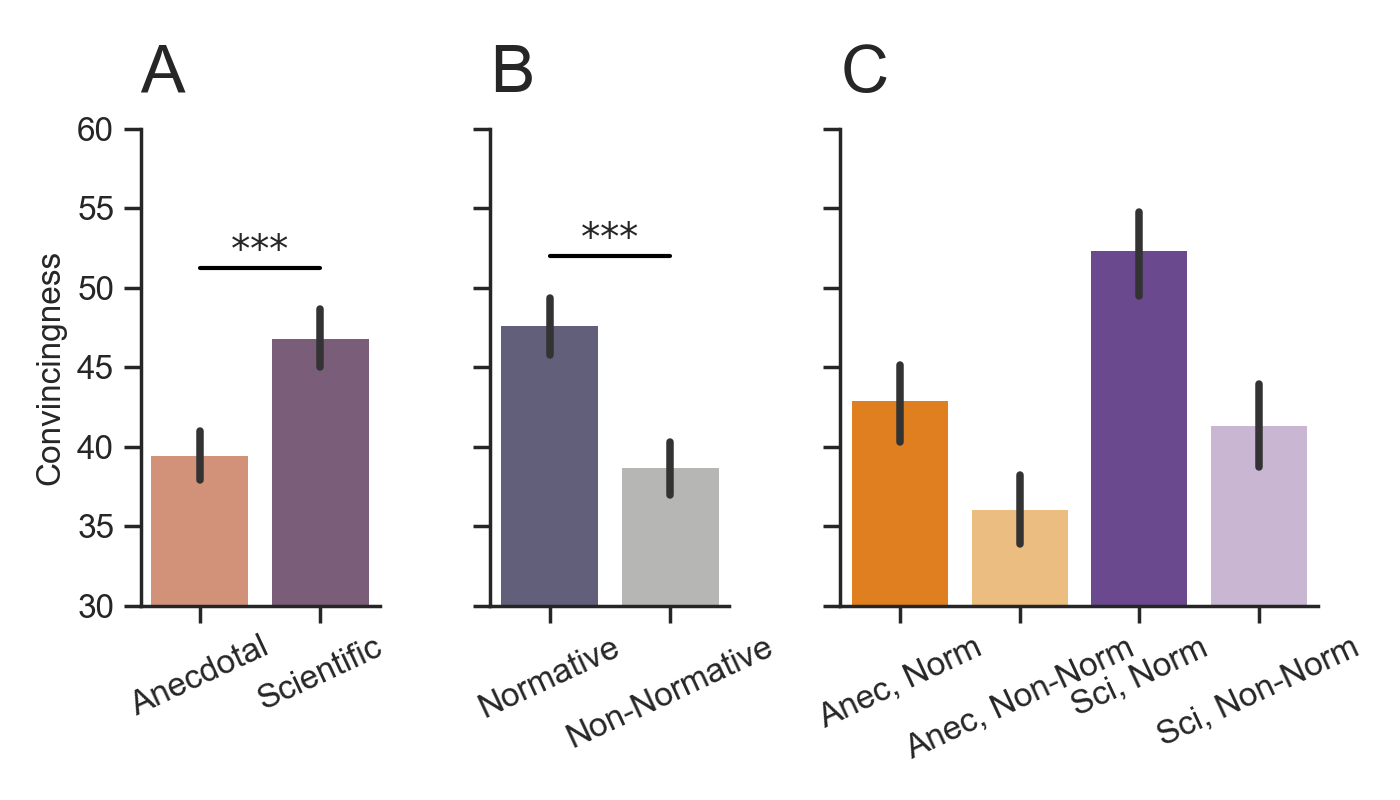

In [124]:
pal1 = ["#E18B6B", "#7E587E"]
pal = ["#5E5A80", "#B6B6B4"]


# Plotting
fig, ax = plt.subplots(1,3, figsize=(7,4), gridspec_kw={"width_ratios": [1,1,2]}, sharey=True)
sns.barplot(x="sci_anec", y="convincing", data=AVDATA, \
            palette=pal1, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[0]) 
sns.despine()
ax[0].set_xlabel("");
ax[0].set_xticklabels(["Anecdotal", "Scientific"], rotation=25)
ax[0].set_ylabel("Convincingness");
#plt.ylim(0,7.5)
datahandles = np.array([L.get_xydata() for L in ax[0].get_lines()])
_, p = stats.ttest_rel(AVDATA.loc[AVDATA["sci_anec"]==0, "convincing"], \
                       AVDATA.loc[AVDATA["sci_anec"]==1, "convincing"])
bff.barplot_annotate_brackets(ax[0], 0, 1, p, datahandles, dh=0.05, fs=14)
bff.panellabel(ax[0], "A")


sns.barplot(x="pop_unpop", y="convincing", data=AVDATA, \
            palette=pal, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[1]) 
sns.despine()
ax[1].set_xlabel("");
ax[1].set_xticklabels(['Normative', "Non-Normative"], rotation=25)
ax[1].set_ylabel("");
#plt.ylim(0,7.5)
datahandles = np.array([L.get_xydata() for L in ax[1].get_lines()])
_, p = stats.ttest_rel(AVDATA.loc[AVDATA["pop_unpop"]==0, "convincing"], \
                       AVDATA.loc[AVDATA["pop_unpop"]==1, "convincing"])
bff.barplot_annotate_brackets(ax[1], 0, 1, p, datahandles, dh=0.05, fs=14)
bff.panellabel(ax[1], "B")


sns.barplot(x="cond", y="convincing", data=AVDATA, \
            palette=cust_palette, linewidth = 0, edgecolor=".2", errcolor=".2", \
            ax=ax[2]) 
ax[2].set_xlabel("");
ax[2].set_xticklabels(["Anec", "Sci"])
ax[2].set_xticklabels(ticklbl, rotation=25);
ax[2].set_ylabel("");
plt.ylim(30,60)
bff.panellabel(ax[2], "C")


plt.tight_layout()
plt.savefig('figsap.tif', dpi=900, format="tiff")

In [66]:
AVDATA.head()

,partnum,cond,RdeltaB,convincing,itemnum,age,party,twitter,trust
0,0.0,0.0,-0.909091,35.272727,16.454545,19.0,1.0,0.0,89.0
1,0.0,1.0,-1.375000,33.875000,17.250000,19.0,1.0,0.0,89.0
2,0.0,2.0,2.714286,52.142857,13.571429,19.0,1.0,0.0,89.0
3,0.0,3.0,-4.166667,42.000000,13.666667,19.0,1.0,0.0,89.0
4,1.0,0.0,1.909091,55.090909,12.181818,20.0,1.0,0.0,80.0


In [107]:
pg.rm_anova(dv='RdeltaB', within=['pop_unpop', "sci_anec"], subject='partnum', data=AVDATA)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,pop_unpop,451.817,1,199,451.817,10.274,0.001572,0.001572,0.049,1.0
1,sci_anec,331.694,1,199,331.694,6.817,0.009719,0.009719,0.033,1.0
2,pop_unpop * sci_anec,29.491,1,199,29.491,0.931,0.335806,0.335806,0.005,1.0


In [108]:
pg.rm_anova(dv='RdeltaB', within=["cond"], subject='partnum', data=AVDATA)

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,cond,3,597,6.54,0.000235,0.000294,0.032,0.96,False,0.935,0.020374


In [127]:
pg.mediation_analysis(data=AVDATA, x='cond', m='convincing', y='RdeltaB', seed=42, n_boot=1000)


,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,convincing ~ X,1.1591,0.5922,5.065636e-02,-0.0033,2.3215,No
1,Y ~ convincing,0.0831,0.0132,5.783932e-10,0.0571,0.1091,Yes
2,Total,0.2145,0.2275,3.458953e-01,-0.2320,0.6610,No
3,Direct,0.1187,0.2228,5.942023e-01,-0.3186,0.5561,No
4,Indirect,0.0958,0.0508,3.400000e-02,0.0042,0.2019,Yes


In [52]:
AVDATA = AVDATA.groupby(["partnum", "sci_anec"], as_index=False).mean()

In [4]:
%R library('mediation')

R[write to console]: Loading required package: MASS

R[write to console]: Loading required package: mvtnorm

R[write to console]: Loading required package: sandwich

R[write to console]: mediation: Causal Mediation Analysis
Version: 4.5.0




array(['mediation', 'sandwich', 'mvtnorm', 'MASS', 'lmerTest', 'lme4',
       'Matrix', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

In [54]:
%Rpush AVDATA

In [63]:
%%R

M <- lm(RdeltaB ~ sci_anec, subject='partnum', data = AVDATA)
summary(M)


Call:
lm(formula = RdeltaB ~ sci_anec, data = AVDATA, subject = "partnum")

Residuals:
     Min       1Q   Median       3Q      Max 
-24.7451  -3.2581  -0.5278   3.1471  23.1633 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.7489     0.3999   4.373 1.57e-05 ***
sci_anec      1.2878     0.5656   2.277   0.0233 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.656 on 398 degrees of freedom
Multiple R-squared:  0.01286,	Adjusted R-squared:  0.01038 
F-statistic: 5.185 on 1 and 398 DF,  p-value: 0.02332



In [57]:
%%R

M <- lm(convincing ~ sci_anec, subject='partnum', data = AVDATA)
summary(M)


Call:
lm(formula = convincing ~ sci_anec, data = AVDATA, subject = "partnum")

Residuals:
    Min      1Q  Median      3Q     Max 
-45.782  -7.648   2.573   9.828  38.343 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   39.424      1.117  35.285  < 2e-16 ***
sci_anec       7.358      1.580   4.657 4.38e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 15.8 on 398 degrees of freedom
Multiple R-squared:  0.05167,	Adjusted R-squared:  0.04929 
F-statistic: 21.69 on 1 and 398 DF,  p-value: 4.382e-06



In [58]:
%%R

M <- lm(RdeltaB ~ sci_anec + convincing, subject='partnum', data = AVDATA)
summary(M)


Call:
lm(formula = RdeltaB ~ sci_anec + convincing, data = AVDATA, 
    subject = "partnum")

Residuals:
     Min       1Q   Median       3Q      Max 
-21.2183  -3.3320  -0.5924   2.9100  21.3926 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.29916    0.79438  -1.635    0.103    
sci_anec     0.71890    0.56779   1.266    0.206    
convincing   0.07732    0.01754   4.408 1.35e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.529 on 397 degrees of freedom
Multiple R-squared:  0.05892,	Adjusted R-squared:  0.05418 
F-statistic: 12.43 on 2 and 397 DF,  p-value: 5.823e-06



In [59]:
%%R
?mediate
fitM <- lm(convincing ~ sci_anec,     data=AVDATA) #IV on M; Hours since dawn predicting coffee consumption
fitY <- lm(RdeltaB ~ sci_anec + convincing, data=AVDATA) #IV and M on DV; Hours since dawn and coffee predicting wakefulness
fitM


Call:
lm(formula = convincing ~ sci_anec, data = AVDATA)

Coefficients:
(Intercept)     sci_anec  
     39.424        7.358  



In [60]:
%%R
fitY


Call:
lm(formula = RdeltaB ~ sci_anec + convincing, data = AVDATA)

Coefficients:
(Intercept)     sci_anec   convincing  
   -1.29916      0.71890      0.07732  



In [61]:
%%R
fitMed <- mediate(fitM, fitY, treat="sci_anec", mediator="convincing")
summary(fitMed)


Causal Mediation Analysis 

Quasi-Bayesian Confidence Intervals

               Estimate 95% CI Lower 95% CI Upper p-value    
ACME              0.570        0.257         1.00  <2e-16 ***
ADE               0.742       -0.384         1.85    0.18    
Total Effect      1.312        0.170         2.43    0.03 *  
Prop. Mediated    0.429        0.136         1.59    0.03 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Sample Size Used: 400 


Simulations: 1000 



In [64]:
%%R
#Bootstrap
fitMedBoot <- mediate(fitM, fitY, boot=TRUE, sims=10000, treat="sci_anec", mediator="convincing")
summary(fitMedBoot)

R[write to console]: Running nonparametric bootstrap





Causal Mediation Analysis 

Nonparametric Bootstrap Confidence Intervals with the Percentile Method

               Estimate 95% CI Lower 95% CI Upper p-value    
ACME              0.569        0.222         1.01  0.0004 ***
ADE               0.719       -0.479         1.90  0.2342    
Total Effect      1.288        0.143         2.39  0.0260 *  
Prop. Mediated    0.442        0.115         2.22  0.0264 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Sample Size Used: 400 


Simulations: 10000 



In [69]:
AVDATA = AVDATA.groupby(["partnum", "pop_unpop"], as_index=False).mean()
AVDATA.head()

,partnum,pop_unpop,cond,sci_anec,RdeltaB,convincing,itemnum,age,party,twitter,trust
0,0.0,0.0,1.0,0.5,0.902597,43.707792,15.012987,19.0,1.0,0.0,89.0
1,0.0,1.0,2.0,0.5,-2.770833,37.937500,15.458333,19.0,1.0,0.0,89.0
2,1.0,0.0,1.0,0.5,1.787879,61.128788,15.757576,20.0,1.0,0.0,80.0
3,1.0,1.0,2.0,0.5,0.500000,38.150000,17.100000,20.0,1.0,0.0,80.0
4,2.0,0.0,1.0,0.5,-12.190476,40.761905,16.142857,19.0,1.0,0.0,77.0


In [70]:
%Rpush AVDATA

In [71]:
%%R

M <- lm(RdeltaB ~ pop_unpop, subject='partnum', data = AVDATA)
summary(M)


Call:
lm(formula = RdeltaB ~ pop_unpop, data = AVDATA, subject = "partnum")

Residuals:
     Min       1Q   Median       3Q      Max 
-18.0913  -3.2917  -0.3852   3.0189  22.6811 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.1443     0.3925   8.010 1.28e-14 ***
pop_unpop    -1.5030     0.5551  -2.708  0.00707 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.551 on 398 degrees of freedom
Multiple R-squared:  0.01809,	Adjusted R-squared:  0.01562 
F-statistic: 7.331 on 1 and 398 DF,  p-value: 0.007071



In [72]:
%%R

M <- lm(convincing ~ pop_unpop, subject='partnum', data = AVDATA)
summary(M)


Call:
lm(formula = convincing ~ pop_unpop, data = AVDATA, subject = "partnum")

Residuals:
    Min      1Q  Median      3Q     Max 
-45.230  -9.089   2.973  10.115  34.733 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   47.563      1.111  42.807  < 2e-16 ***
pop_unpop     -8.921      1.571  -5.677 2.64e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 15.71 on 398 degrees of freedom
Multiple R-squared:  0.07492,	Adjusted R-squared:  0.0726 
F-statistic: 32.23 on 1 and 398 DF,  p-value: 2.639e-08



In [73]:
%%R

M <- lm(RdeltaB ~ pop_unpop + convincing, subject='partnum', data = AVDATA)
summary(M)


Call:
lm(formula = RdeltaB ~ pop_unpop + convincing, data = AVDATA, 
    subject = "partnum")

Residuals:
     Min       1Q   Median       3Q      Max 
-18.4487  -3.3562  -0.4916   2.7659  23.1969 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.73447    0.90530  -0.811    0.418    
pop_unpop   -0.77550    0.56229  -1.379    0.169    
convincing   0.08155    0.01725   4.727 3.17e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.408 on 397 degrees of freedom
Multiple R-squared:  0.07041,	Adjusted R-squared:  0.06572 
F-statistic: 15.03 on 2 and 397 DF,  p-value: 5.084e-07



In [74]:
%%R
?mediate
fitM <- lm(convincing ~ pop_unpop,     data=AVDATA) #IV on M; Hours since dawn predicting coffee consumption
fitY <- lm(RdeltaB ~ pop_unpop + convincing, data=AVDATA) #IV and M on DV; Hours since dawn and coffee predicting wakefulness
fitM


Call:
lm(formula = convincing ~ pop_unpop, data = AVDATA)

Coefficients:
(Intercept)    pop_unpop  
     47.563       -8.921  



In [75]:
%%R
fitY


Call:
lm(formula = RdeltaB ~ pop_unpop + convincing, data = AVDATA)

Coefficients:
(Intercept)    pop_unpop   convincing  
   -0.73447     -0.77550      0.08155  



In [76]:
%%R
fitMed <- mediate(fitM, fitY, treat="pop_unpop", mediator="convincing")
summary(fitMed)


Causal Mediation Analysis 

Quasi-Bayesian Confidence Intervals

               Estimate 95% CI Lower 95% CI Upper p-value    
ACME             -0.731       -1.184        -0.36  <2e-16 ***
ADE              -0.788       -1.930         0.31   0.166    
Total Effect     -1.519       -2.623        -0.38   0.008 ** 
Prop. Mediated    0.470        0.214         1.62   0.008 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Sample Size Used: 400 


Simulations: 1000 



In [77]:
%%R
#Bootstrap
fitMedBoot <- mediate(fitM, fitY, boot=TRUE, sims=10000, treat="pop_unpop", mediator="convincing")
summary(fitMedBoot)

R[write to console]: Running nonparametric bootstrap





Causal Mediation Analysis 

Nonparametric Bootstrap Confidence Intervals with the Percentile Method

               Estimate 95% CI Lower 95% CI Upper p-value    
ACME             -0.728       -1.190        -0.34  <2e-16 ***
ADE              -0.775       -1.957         0.35  0.1778    
Total Effect     -1.503       -2.619        -0.43  0.0064 ** 
Prop. Mediated    0.484        0.183         1.63  0.0064 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Sample Size Used: 400 


Simulations: 10000 

